# Dynamic Equations as Vector Field Generators

$$ f(x,y) = \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} y \\ -x \end{bmatrix} $$

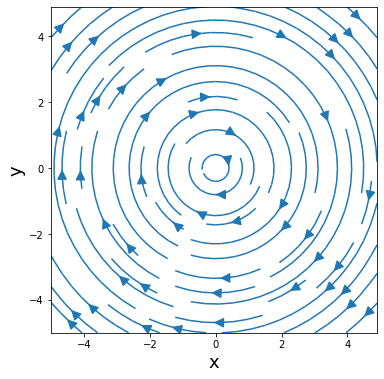

In [118]:
import numpy as np 
import matplotlib.pyplot as plt 

# 1D arrays 
x = np.arange(-5,5,0.1) 
y = np.arange(-5,5,0.1) 
  
# Meshgrid 
X, Y = np.meshgrid(x,y)

# Dynamics
def f(x, y):
    return np.array([y, -x])

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.gca().set_aspect('equal')
plt.show()


$$\begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} y \\ x \end{bmatrix} $$

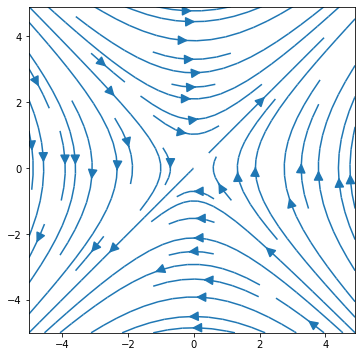

In [109]:
# Dynamics
def f(x, y):
    return np.array([y, x])

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.gca().set_aspect('equal')
plt.show()

$$ \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} -x^3 \\ -y^3 \end{bmatrix} $$

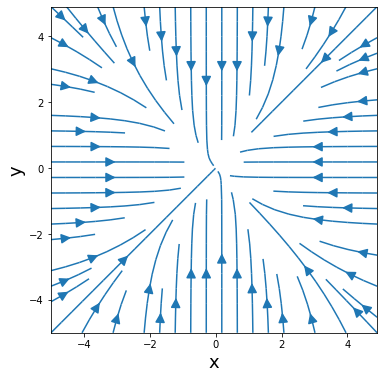

In [117]:
# Dynamics
def f(x, y):
    return np.array([-x**3, -y**3])

# Compute vector field
X_dot, Y_dot = f(X,Y)

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, X_dot, Y_dot, density=.75, arrowsize=2)
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.gca().set_aspect('equal')

plt.show()

# Implementing Control Lyapunov Functions (CLFs)

$$\dot{x} = \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = f(x) + u =  \begin{bmatrix} x_2 \\ -x_1 \end{bmatrix} + \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} $$

$$ V(x) = \frac{1}{2} (x_1^2 + x_2^2) $$

$$\dot{V}(x,u) = \frac{\partial V}{\partial x} \frac{\partial x}{\partial t} = \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix} x_2 + u_1 \\ -x_1 + u_2\end{bmatrix} = x_1(x_2 + u_1) + x_2(-x_1 + u_2) $$

In [ ]:
# Dynamics
A = np.array([[0, 1],
              [-1, 0]])
def f(x):
    return A@x

def V(x):
    return .5*(np.sum(x**2))

def dVdx(x):
    return x.T

